While there are a lot of different libraries to perform beat tracking, 
it seems like librosas dynamic programming is the most apparent one.

 

In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy

Loading the listening sample. Try some normalization and low pass filtering

In [2]:
x, sr = librosa.load('loudly.mp3') 


x = librosa.util.normalize(x) 

b, a = scipy.signal.butter(1, 30 / (sr / 2), btype='high')
x = scipy.signal.filtfilt(b, a, x)


ipd.Audio(x, rate=sr)

c:\Users\const\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Get the raw estimated BPM and beat times using DP.

In [3]:
tempo, beat_times = librosa.beat.beat_track(y=x, sr=sr, units='time')
print(tempo, beat_times)

[89.10290948] [ 3.36689342  4.04027211  4.69043084  5.38702948  6.03718821  6.71056689
  7.36072562  8.03410431  8.70748299  9.38086168 10.03102041 10.70439909
 11.37777778 12.02793651 12.70131519 13.37469388 14.02485261 14.69823129
 15.37160998 16.04498866 16.69514739 17.36852608 18.04190476 18.71528345
 19.36544218 20.03882086 20.68897959 21.38557823 22.03573696]


Sanity checking, by putting the estimated beat times on top of the audio

In [4]:
clicks = librosa.clicks(times=beat_times, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

Visualize the waveform with the added beats

(-1.0, 1.0)

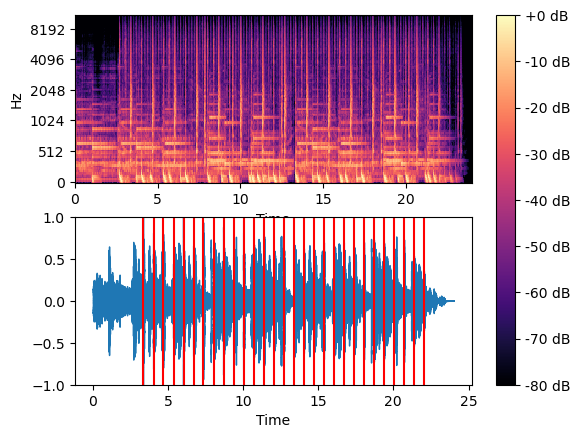

In [5]:
librosa.feature.melspectrogram(y=x, sr=sr)

S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,
                                    )

fig, ax = plt.subplots(nrows=2)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                          ax=ax[0])
fig.colorbar(img, ax=ax, format='%+2.0f dB')
librosa.display.waveshow(x, sr=sr, ax=ax[1])
plt.vlines(beat_times, -1, 1, color='r')
plt.ylim(-1, 1)



The results seem quite satisfying. However, the first two beats were not catched properly.
I'd like to try another approach, combining the hilbert transformation and the find peaks library.


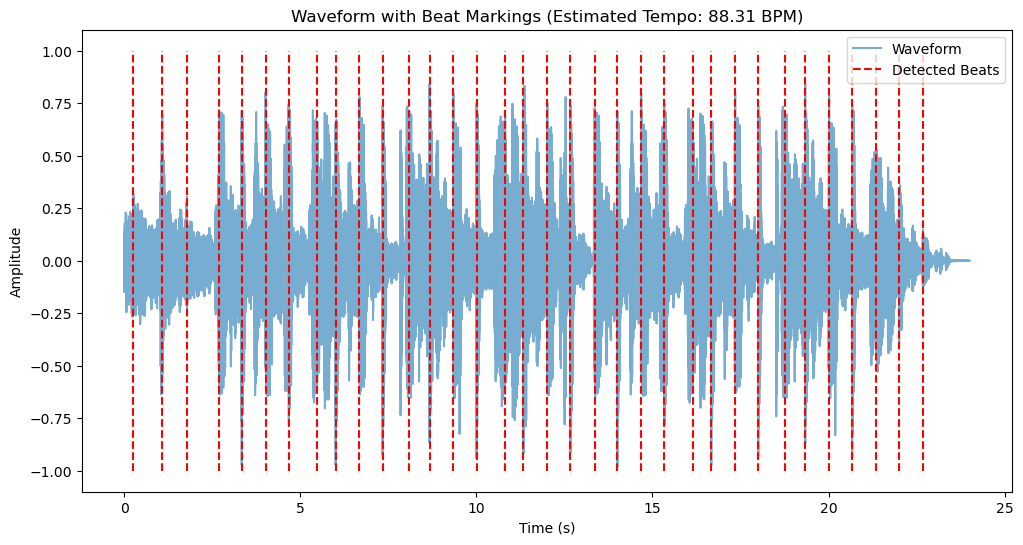

In [6]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.signal

audio_path = "loudly.mp3"
y, sr = sf.read(audio_path, always_2d=True)  
y = np.mean(y, axis=1)  

analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

peaks, _ = scipy.signal.find_peaks(envelope, height=np.mean(envelope), distance=sr/2)

beat_times = peaks / sr

if len(beat_times) > 1:
    beat_intervals = np.diff(beat_times)
    estimated_tempo = 60 / np.mean(beat_intervals)
else:
    estimated_tempo = None  

plt.figure(figsize=(12, 6))
time = np.arange(len(y)) / sr
plt.plot(time, y, alpha=0.6, label="Waveform")
plt.vlines(beat_times, ymin=-1, ymax=1, color='r', linestyle='--', label="Detected Beats")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Waveform with Beat Markings (Estimated Tempo: {estimated_tempo:.2f} BPM)")
plt.legend()
plt.show()

clicks = librosa.clicks(times=beat_times, sr=sr, length=len(y), click_duration=0.02)

y_with_clicks = y + 0.3 * clicks  
y_with_clicks = np.clip(y_with_clicks, -1, 1)  


sf.write("output.wav", y_with_clicks, sr)

The first two peaks were catched successfully; However, now we have some false positives.

Finally, I do like to try a Deep Learning approach, pre trained by MadMom.

tempo, beat_times = librosa.beat.beat_track(y=analytical_signal, sr=sr, units='time')
print(tempo, beat_times)

clicks = librosa.clicks(times=beat_times, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

In [ ]:
%pip uninstall numpy scipy
%pip install numpy==1.22.4 scipy==1.8.1

import madmom 
import librosa
import IPython.display as ipd
# approach 2 - dbn tracker
x, sr = librosa.load('loudly.mp3') 
x = librosa.util.normalize(x) 

proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
act = madmom.features.beats.RNNBeatProcessor()('loudly.mp3')
beat_times = proc(act)

clicks = librosa.clicks(times=beat_times, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name '__all__' from 'numpy.linalg' (c:\Users\const\anaconda3\envs\Whisper\lib\site-packages\numpy\linalg\__init__.py)

Thought process: 
1. Understanding concept of beats 
2. Look up existing work on beat tracking & understand the basics 
3. Implement and compare results 
4. Thinking about qualitative evaluation metrics to evaluate the results (qualitative, as we have only a single sample) 
5. Possible preprocessing to improve the results? (f.e mean, hilbert, noise filtering, FFT) 



Bonus:

I think building a deep leanring network from scratch and training on a publicly available dataset would be a lot of fun!

Key aspects to analyze would: 
- be emotional tone of a given music snippet
- filtering single components (f.e a specific instrument thats been used, or the voice of the singer)
- automatic special events location